In [83]:
!pip install -q --upgrade pip
!pip install -q --upgrade numpy
!pip install -q --upgrade scipy
!pip install -q --upgrade matplotlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import os
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt, iirfilter, freqs, lfilter, lfilter_zi
import json

DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be fou

In [84]:
logFilePath = "../../../logs"
batchSize = 100

In [85]:
def findLatestLogFile():
    list_of_files = glob.glob(os.path.join(logFilePath, '*.log'))
    latest_file = max(list_of_files, key=os.path.getctime)
    print("Latest file: ", latest_file)
    return latest_file

In [96]:
def readADCData(logfile):
    # Each line is formatted like this:
    # T 60588.800 2301 2009 2015 2003 2311.97 60598192 1820.18 60588739 RMS 4.43 ZXT 60587477 mean 2165.00 last-mean -124.00

    # Log data
    timestamps = []
    adc_value = []
    peak_values = []
    rms = []
    zxt = []
    mean_adc = []
    last_adc = []

    # Read the file
    with open(logfile) as f:
        lines = f.readlines()

        # Iterate over each line
        for line in lines:

            # Check if the line is a sample
            if "T " in line:
                # Extract the timestamp and the ADC value
                parts = line.split(' ')
                timestamps.append(float(parts[1]) * 1000)
                adc_value.append(int(parts[3]))
                peak_values.append((float(parts[5]), int(parts[6]), float(parts[8]), int(parts[9])))
                rms.append(float(parts[11]))
                zxt.append(int(parts[13]))
                mean_adc.append(float(parts[15]))
                last_adc.append(float(parts[17]))

    # Debug
    print("Read", len(timestamps), "samples")

    # Convert to numpy arrays
    timestamps = np.array(timestamps)
    adc_value = np.array(adc_value)
    peak_values = np.array(peak_values)
    rms = np.array(rms)
    zxt = np.array(zxt)
    mean_adc = np.array(mean_adc)
    last_adc = np.array(last_adc)

    # Find indices where changes occur
    zxt = np.where(np.diff(zxt) != 0)[0]

    print(zxt)
    
    return timestamps, adc_value, peak_values, rms, zxt, mean_adc, last_adc

Latest file:  ../../../logs/20240220-220131.log
Read 2000 samples
[  99  159  176  199  203  225  247  272  297  299  311  335  359  383
  399  418  441  465  490  499  503  528  551  575  599  612  635  657
  679  699  723  749  773  794  799  810  835  859  884  899  921  945
  966  989  999 1007 1029 1054 1078 1099 1118 1140 1164 1189 1199 1206
 1231 1256 1278 1299 1319 1344 1368 1389 1399 1407 1430 1455 1479 1499
 1519 1543 1567 1591 1599 1607 1629 1654 1678 1699 1722 1799 1804 1899
 1938 1963]


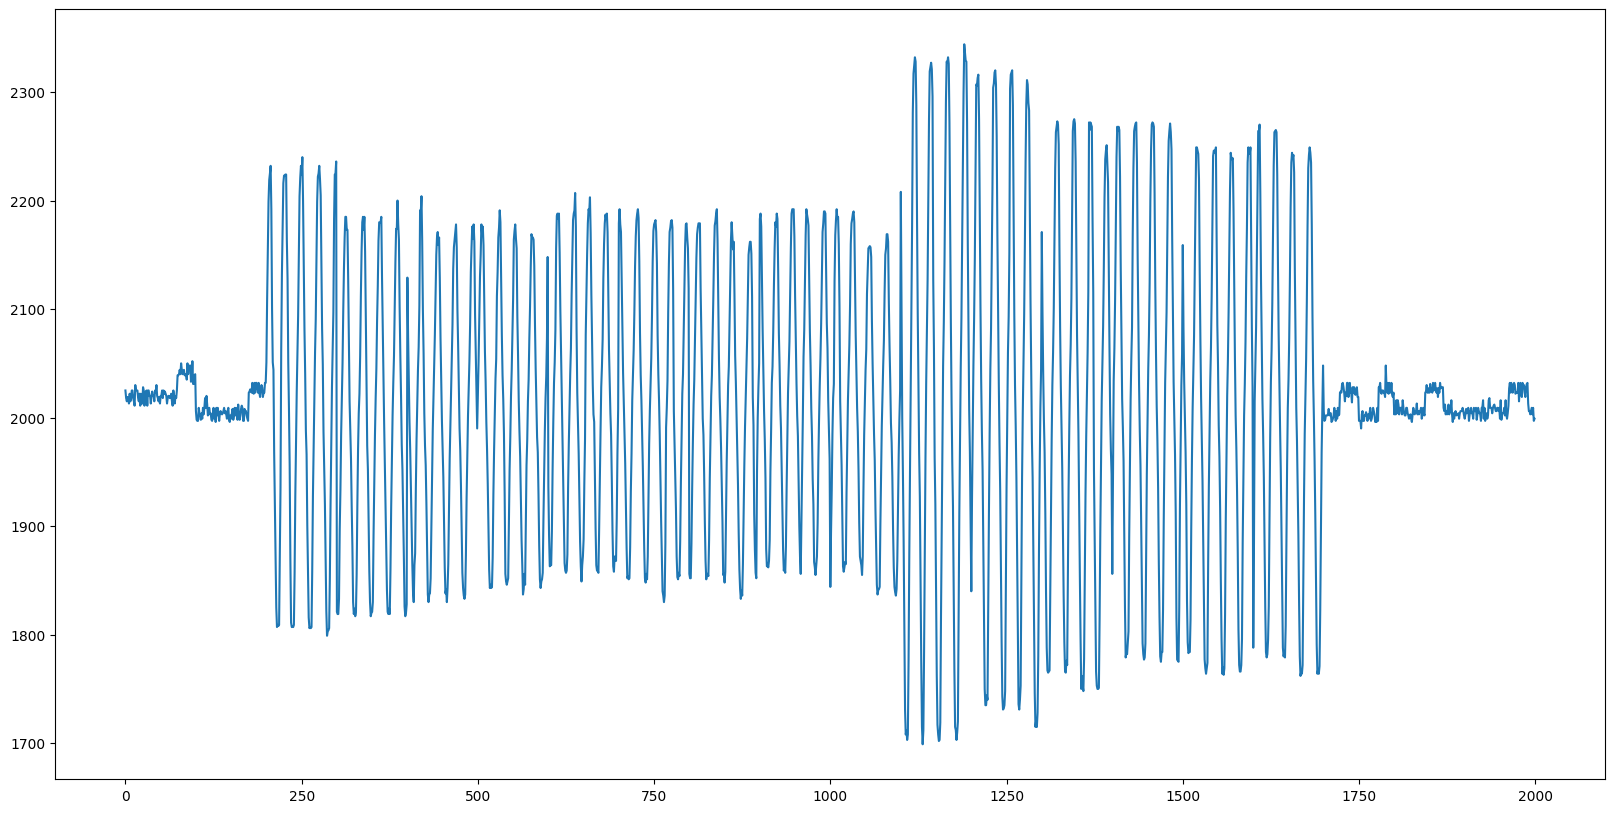

In [97]:
if __name__ == "__main__":

    # Set plot size
    matplotlib.rcParams['figure.figsize'] = [20, 10]
    
    # Find the latest log file
    logfile = findLatestLogFile()

    # Read the data
    timestamps, adc_value, peak_values, rms, zxt, mean_adc, last_adc = readADCData(logfile)

    # Plot the adc_value vs index
    plt.plot(range(len(adc_value)), adc_value, label="ADC Value")

    # Show the plot
    plt.show()

[5.580400e+06 5.580800e+06 5.581200e+06 ... 1.006392e+08 1.006396e+08
 1.006400e+08]
[  99  159  176  199  203  225  247  272  297  299  311  335  359  383
  399  418  441  465  490  499  503  528  551  575  599  612  635  657
  679  699  723  749  773  794  799  810  835  859  884  899  921  945
  966  989  999 1007 1029 1054 1078 1099 1118 1140 1164 1189 1199 1206
 1231 1256 1278 1299 1319 1344 1368 1389 1399 1407 1430 1455 1479 1499
 1519 1543 1567 1591 1599 1607 1629 1654 1678 1699 1722 1799 1804 1899
 1938 1963]
[2025.    0. 2025.    0.]


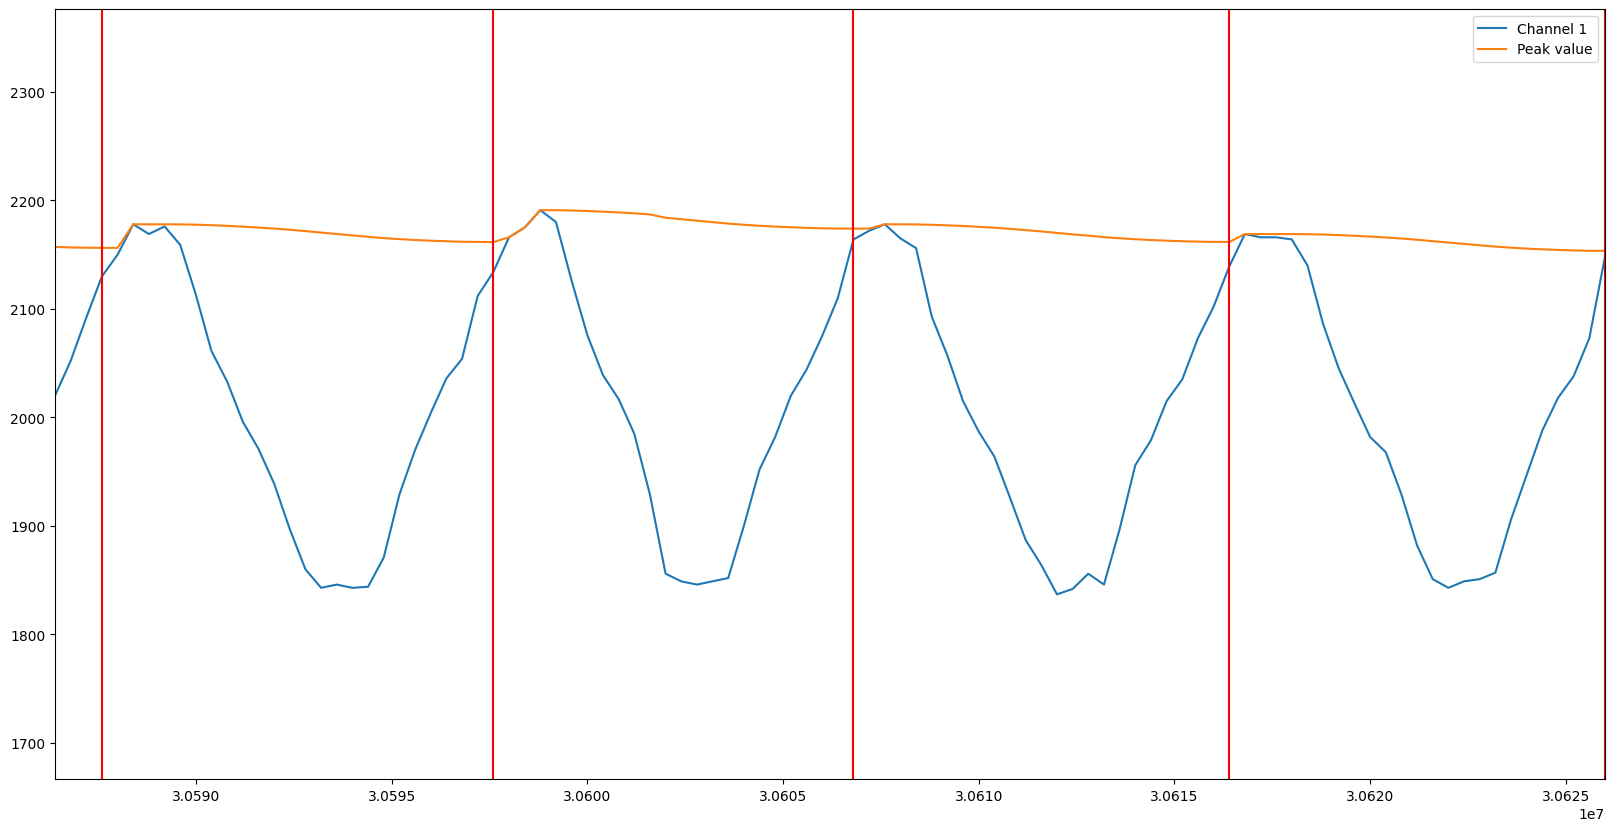

In [98]:
print(timestamps)
print(zxt)
# Plot peak pos adc_ch1
print(peak_values[0])
plt.plot(timestamps, adc_value, label="Channel 1")
plt.plot(timestamps, peak_values[0:,0], label="Peak value")

# Plot the zero crossings
for i in range(len(zxt)):
    plt.axvline(x=timestamps[zxt[i]], color='r')

# Show the plot
plt.legend()

plotStart = 500
plt.xlim([timestamps[plotStart], timestamps[plotStart + batchSize - 1]])
plt.show()

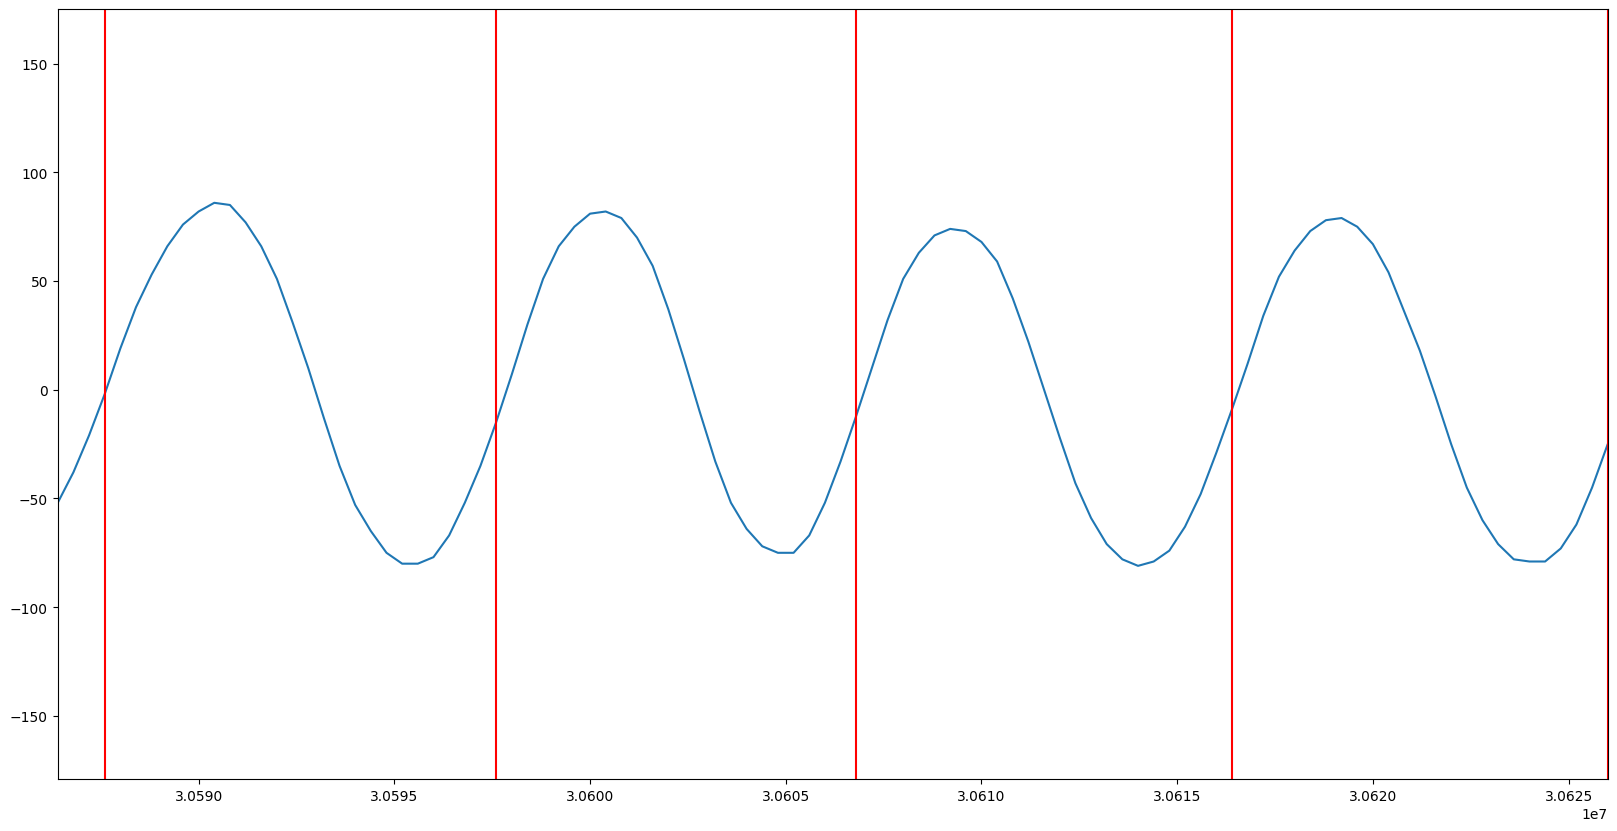

In [99]:
# Plot AC ADC value and zero crossing time
plt.plot(timestamps, last_adc)
plt.xlim([timestamps[plotStart], timestamps[plotStart + batchSize - 1]])
# Plot the zero crossings
for i in range(len(zxt)):
    plt.axvline(x=timestamps[zxt[i]], color='r')
plt.show()

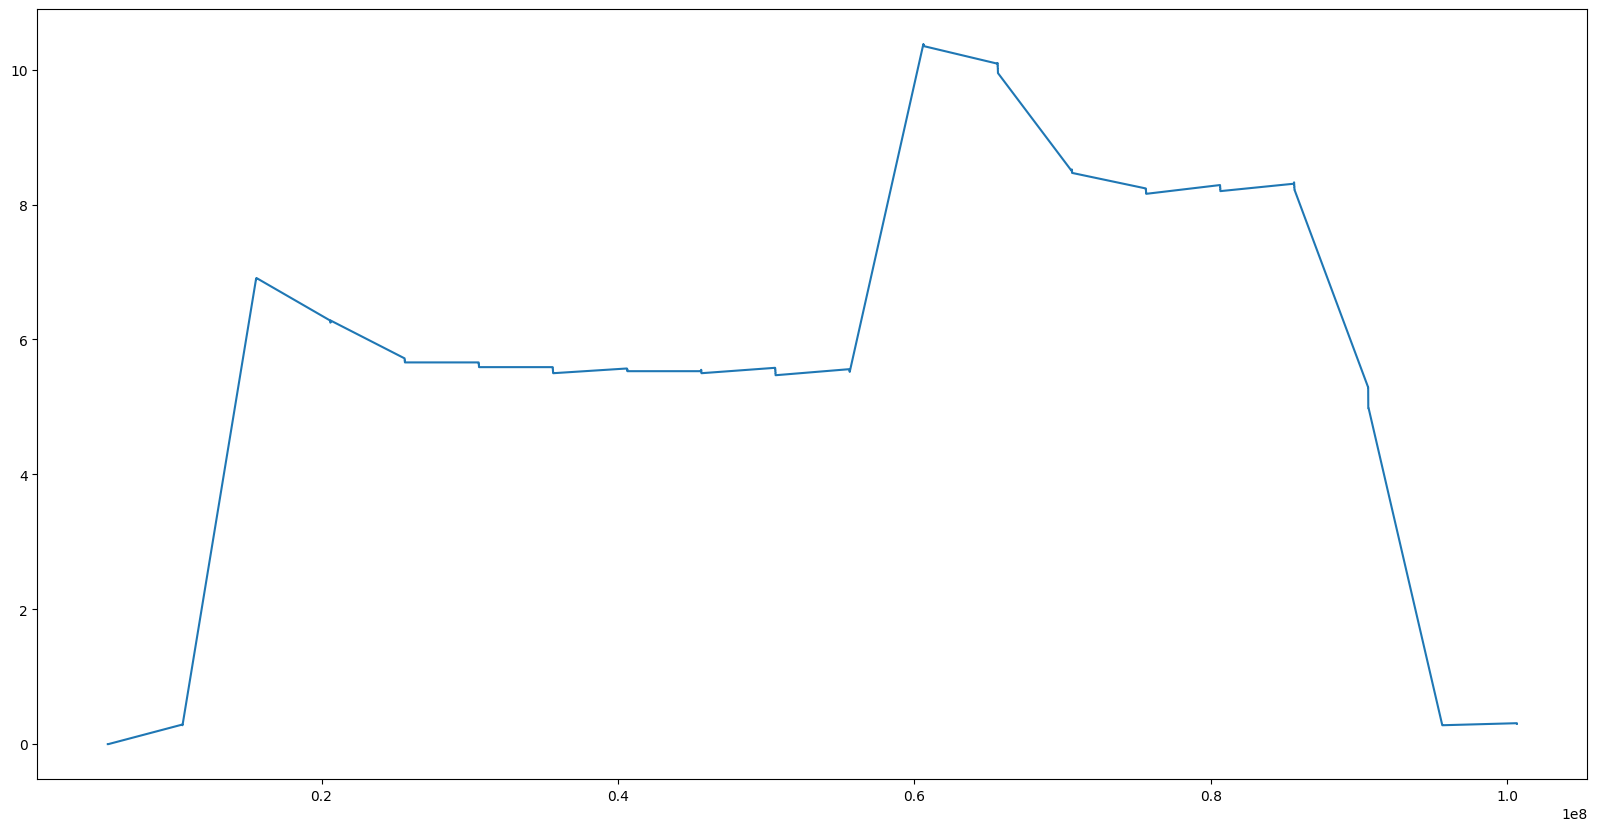

In [100]:
# Plot rms current data
plt.plot(timestamps, rms)
# plt.xlim([timestamps[plotStart], timestamps[plotStart + batchSize - 1]])
plt.show()

# # Get min and max values in above range
# min_adc = np.min(adc_ch1[1000:1480])
# max_adc = np.max(adc_ch1[1000:1480])
# print("Min ADC: ", min_adc)
# print("Max ADC: ", max_adc)

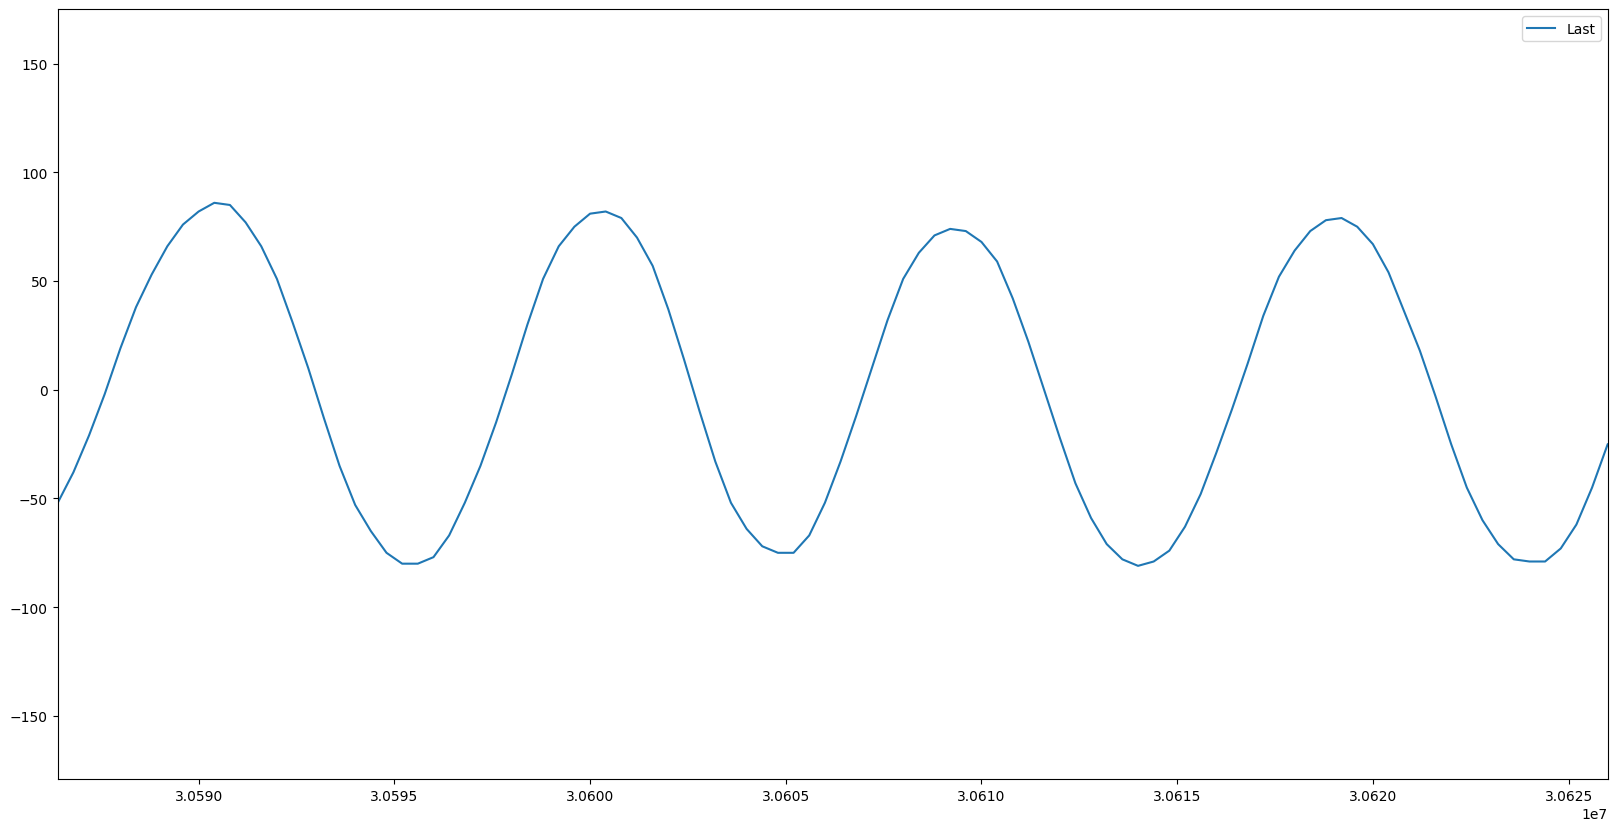

In [101]:
# Plot current data
# plt.plot(timestamps, mean_adc, label="Mean")
plt.plot(timestamps, last_adc, label="Last")
plt.legend()
plt.xlim([timestamps[plotStart], timestamps[plotStart + batchSize - 1]])
plt.show()

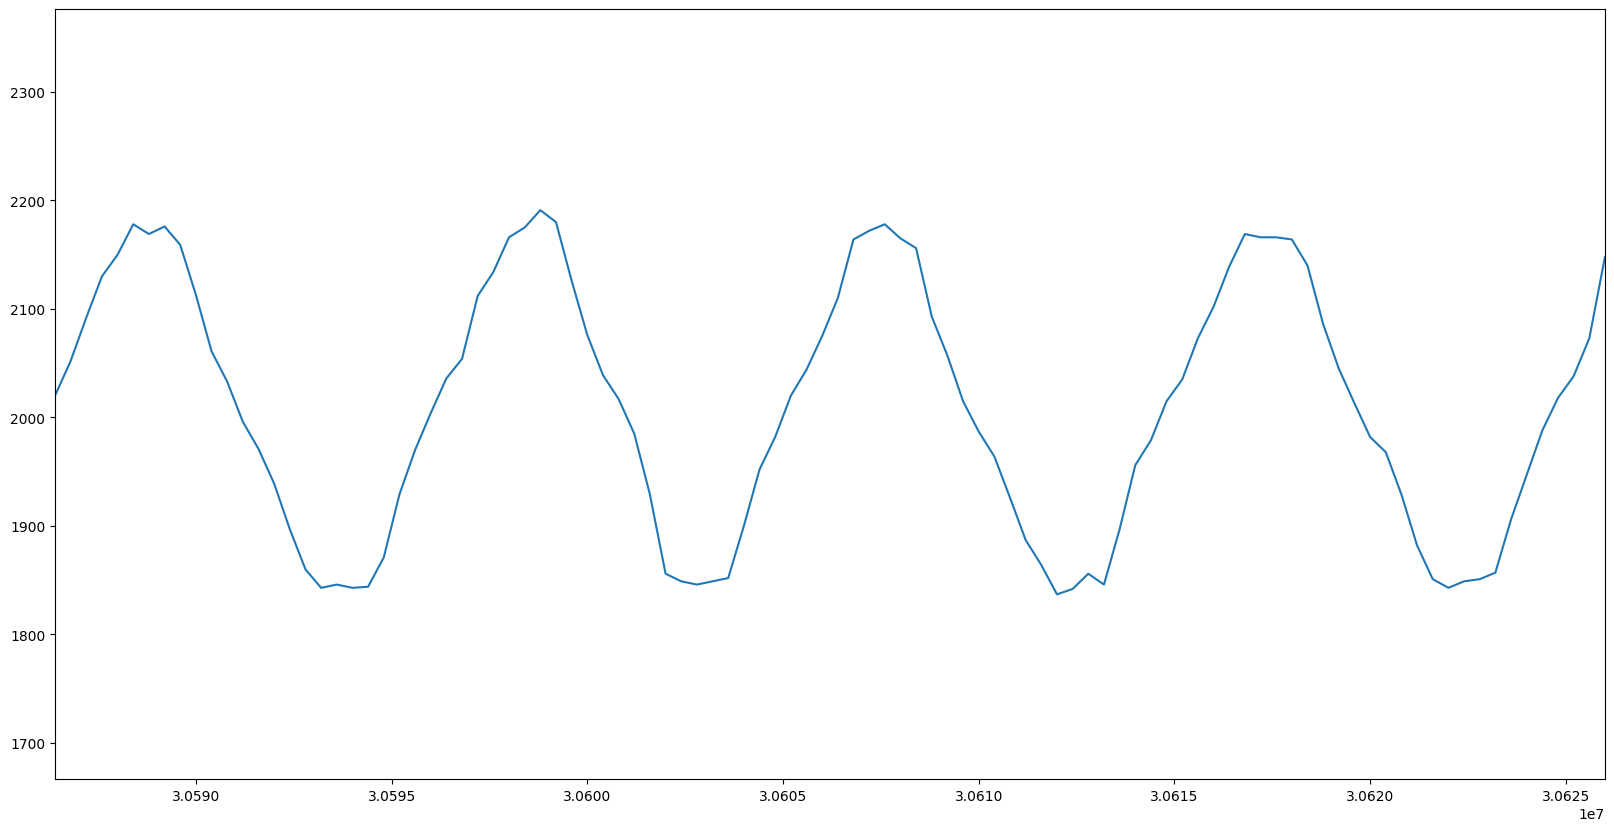

In [102]:
# Plot a chunk of data in a large plot
plt.plot(timestamps, adc_value)
plt.xlim([timestamps[plotStart], timestamps[plotStart + batchSize - 1]])
plt.show()

In [103]:
# Split into batches based on time gaps
time_gaps = np.diff(timestamps)
batch_indices = np.where(time_gaps > 1000)[0]
# Add one to the indices to get the start of the next batch
batch_indices = batch_indices + 1
batch_indices = np.insert(batch_indices, 0, 0)
batch_indices = np.append(batch_indices, len(timestamps))
batches = []
for i in range(len(batch_indices) - 1):
    adc_vals_in_range = adc_value[batch_indices[i]:batch_indices[i+1]]
    # Extract the first element from each tuple
    adc0_in_range = [x for x in adc_vals_in_range]
    batches.append((timestamps[batch_indices[i]:batch_indices[i+1]], adc0_in_range, batch_indices[i], batch_indices[i+1]))

# Extract sample rate from the first batch
sample_rate = 1000000 / np.mean(np.diff(batches[0][0]))
print("Sample rate Hz:", sample_rate)
print(batch_indices)

Sample rate Hz: 2500.0
[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900 2000]


Found 20 batches
Min distance for peak detect: 22
RMS current: 0.5201988714905099
RMS index: 0
RMS current: 0.5286289326171998
RMS index: 100
RMS current: 7.584889786938239
RMS index: 200
RMS current: 6.456121050437329
RMS index: 300
RMS current: 5.705599451512523
RMS index: 400
RMS current: 5.616697003355264
RMS index: 500
RMS current: 5.833278157905724
RMS index: 600
RMS current: 5.955977291587
RMS index: 700
RMS current: 5.634533926812403
RMS index: 800
RMS current: 5.558867105409159
RMS index: 900
RMS current: 5.716570756528778
RMS index: 1000
RMS current: 10.778503736841213
RMS index: 1100
RMS current: 9.94143285070618
RMS index: 1200
RMS current: 8.742916350160282
RMS index: 1300
RMS current: 8.38963307312066
RMS index: 1400
RMS current: 8.201966780815441
RMS index: 1500
RMS current: 8.237043646576119
RMS index: 1600
RMS current: 0.6339365413036229
RMS index: 1700
RMS current: 0.4895516899163969
RMS index: 1800
RMS current: 0.5121086090860024
RMS index: 1900


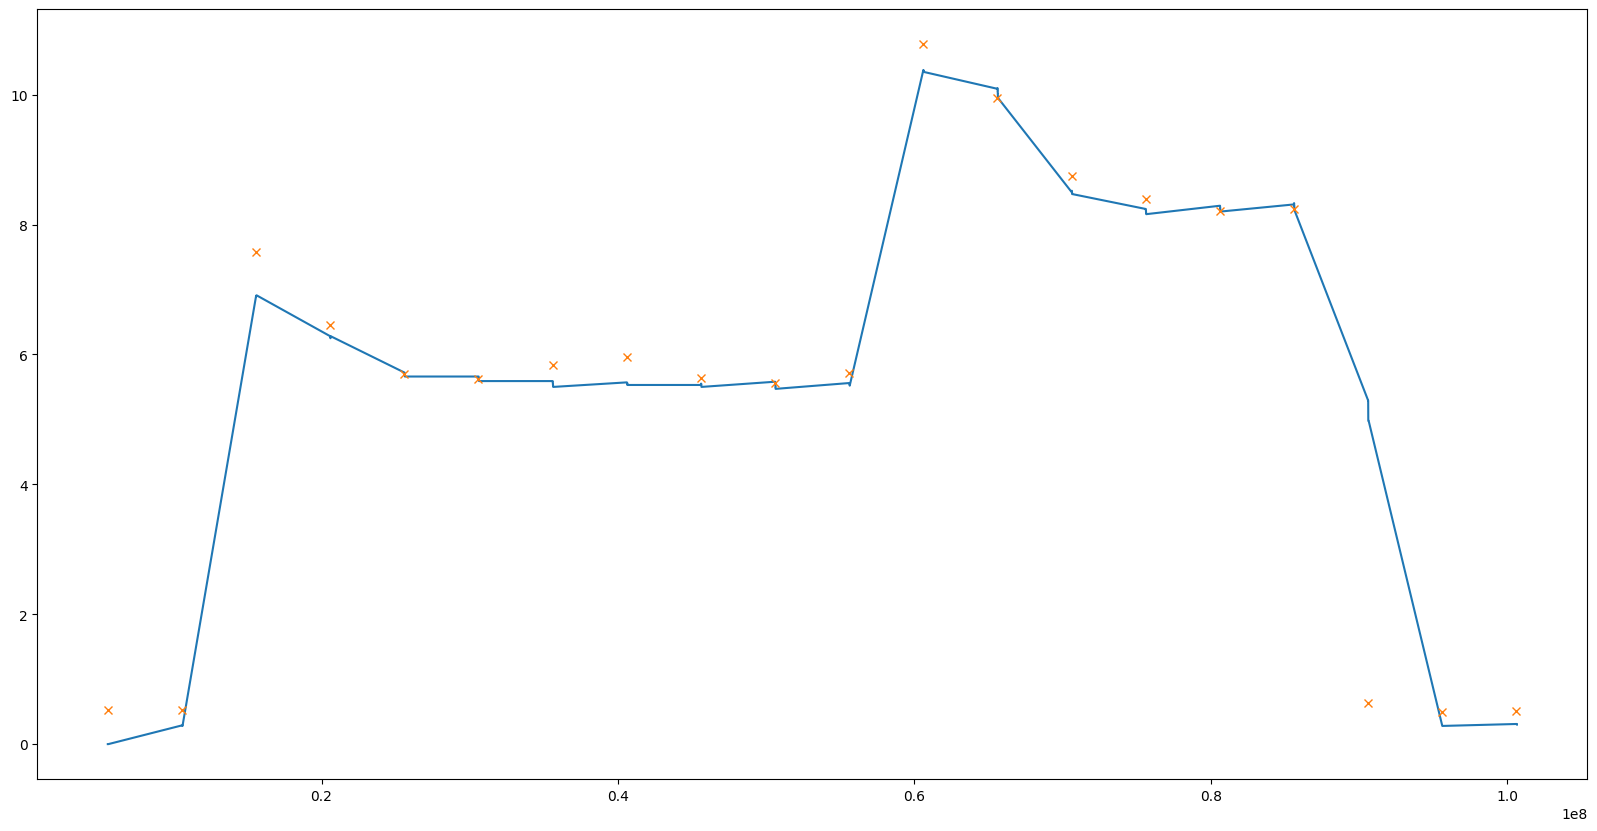

In [104]:
print("Found", len(batches), "batches")

# Signal freq in Hz
signal_freq = 50

# Peak detection min distance
min_distance = int(sample_rate / signal_freq / 2.2)
print("Min distance for peak detect:", min_distance)
rms_calculated = []
rms_indices = []

# Plot the batches
for batch in batches:
    # plt.plot(batch[0], batch[1])
    # plt.show()
    # print("Batch length:", len(batch[0]), "time:", batch[0][0], "to", batch[0][-1])
    # print(batch[0], batch[1])
    # Calculate mean
    mean = np.mean(batch[1])
    # print("Mean:", mean)

    # Calculate current values
    adc_to_current = 0.049
    current = (batch[1] - mean) * adc_to_current

    # # Offset the values
    # batch[1] -= mean

    # # Conversion factor for ADC readings to current
    # batch[1] = batch[1] * adc_to_current

    # # # Plot the batch
    # plt.plot(batch[0], current)
    # plt.show()

    use_peaks = False
    if use_peaks:
        # Find peaks
        peaks, _ = find_peaks(current, height=0.1, distance=min_distance)

        # plt.plot(batch[0], current)
        # plt.plot(batch[0][peaks], current[peaks], "x")
        # plt.show()

        # Check for peaks
        if len(peaks) < 2:
            # print("No peaks found")
            continue

        # Extract the samples between the first and second peak
        first_peak = peaks[0]
        second_peak = peaks[1]
        # print("First peak:", first_peak, "Second peak:", second_peak)
        samples_between_peaks = current[first_peak:second_peak]

        print(f"First peak: {first_peak}, Second peak: {second_peak}, Samples between peaks: {len(samples_between_peaks)}")

        # Plot the samples
        # plt.plot(samples_between_peaks)
        # plt.show()

        # Integrate the samples between the peaks to get the RMS current
        rms_current = np.sqrt(np.mean(samples_between_peaks**2))
        print("RMS current:", rms_current)
        rms_calculated.append(rms_current)
        rms_indices.append(batch[2] + second_peak)
        print("RMS index:", batch[2] + second_peak)
    else:
        # # Apply a second order bandpass filter to the current with a centre frequency of 50 Hz
        # # Filter parameters
        # fs = sample_rate
        # lowcut = 10
        # highcut = 100
        # order = 2
        # nyquist = 0.5 * fs
        # low = lowcut / nyquist
        # high = highcut / nyquist
        # b, a = butter(order, [low, high], btype='band')
        # current = lfilter(b, a, current)

        # Integrate all samples get the RMS current
        rms_current = np.sqrt(np.mean(current**2))
        print("RMS current:", rms_current)
        rms_calculated.append(rms_current)
        rms_indices.append(batch[2])
        print("RMS index:", batch[2])

    # # Plot the batch
    # plt.plot(batch[0], current)
    # plt.plot(batch[0][peaks], current[peaks], "x")
    # # Plot the rms_current as a horizontal line
    # plt.axhline(y=rms_current, color='r', linestyle='-')
    # plt.show()
    
plt.plot(timestamps, rms)
plt.plot(timestamps[rms_indices], rms_calculated, "x")
# plt.xlim([timestamps[1000], timestamps[1480]])
plt.show()

